# Setup

In [1]:
# Standard Python libraries
import sys
import random
import string
import os
import math

# Third party libraries
from pylibdmtx.pylibdmtx import encode
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Custom funcs
sys.path.append('../scripts')
from hourglass import *

cuda


In [2]:
# Some kinda global params
input_size = 256
output_size = 64
n_stacks = 8

# Gaussian distribution (spread) for heatmap generation
sigma = 2

n_train = 800
n_val = 100
n_test = 100

power = 2 # power to use during loss calculation - higher = more emphasis on center of gaussians

Notes on things to try for improvements:
- Smaller heatmaps
- More different stacks
- Try with no augmentations (should be equal to simple viz) and then incrementally add more augments until it breaks again. This could help figure out what type of images it struggles with.
  - Perhaps doing shape transformations on the heatmaps is confusing for the model? Maybe after the shape transformations the heatmaps should be redone so that they are equally sized.
  - Perhaps train in a way where augmentations are gradually introduced as the model learns. The model can learn the simple synthesis easily, so perhaps learning that first and then adding other transformations could allow it to be robust to different types of complexities over time, instead of learning them all at once.
- Some optimization of gpu usage for faster training...
- ...?

losses:
- test 0.06 with 3 stacks and varying epochs/patiences
- test 2.09 with 6 stacks and varying epochs/patiences
- test 36.09 with 6 stacks and early stopping patiences 1 and all epochs 100
- test 0.16 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 5 instead of old of 2)
- test 2.34 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 10 instead of old of 2)
- test 0.13 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 3 instead of old of 2)
- test 0.15 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 2 - should be exactly like the first run!)

# Data Synthesis

In [3]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode, dmc_size):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)

    # upscale image
    img = img.resize((dmc_size, dmc_size), Image.NEAREST)

    return img

def get_corner_coords(img, debug=False):
    '''Returns the coordinates of corners of DMC'''
    padding = 26 # Padding around DMC info zone in pixels (we only want inner modules!)

    raw_coords = [] # Raw pixel coords of dmc corners
    label_info = [] # Line by line label info

    # Get coords of each corner of DMC
    top_left = (padding-1, padding-1)
    top_right = (img.width-padding, padding-1)
    bottom_left = (padding-1, img.height-padding)
    bottom_right = (img.width-padding, img.height-padding)

    # Paint corners red for viz/debug
    if debug:
        img = img.convert('RGB')
        img.putpixel(top_left, (255, 0, 0))
        img.putpixel(top_right, (255, 0, 0))
        img.putpixel(bottom_left, (255, 0, 0))
        img.putpixel(bottom_right, (255, 0, 0))

    # Normalize pixel coords to 0-1
    top_left_norm = [top_left[0] / img.width, top_left[1] / img.height]
    top_right_norm = [top_right[0] / img.width, top_right[1] / img.height]
    bottom_left_norm = [bottom_left[0] / img.width, bottom_left[1] / img.height]
    bottom_right_norm = [bottom_right[0] / img.width, bottom_right[1] / img.height]

    # Add raw coords
    raw_coords.extend([top_left, top_right, bottom_left, bottom_right])

    # Add normalized coords
    label_info.extend([top_left_norm, top_right_norm, bottom_left_norm, bottom_right_norm])

    return raw_coords, label_info, img

def get_heatmaps_basic(img, raw_coords, heatmap_size, debug=False):
    '''Returns "heatmaps" for each corner of DMC, except they are just single points'''
    
    # Create empty heatmaps
    heatmaps = np.zeros((4, heatmap_size, heatmap_size))

    # Create "heatmaps" for each corner
    for i in range(4):
        # Create "heatmap"
        heatmap = np.zeros((heatmap_size, heatmap_size))
        for y in range(img.height):
            for x in range(img.width):
                if x == raw_coords[i][0] and y == raw_coords[i][1]:
                    heatmap[y, x] = 1
        
        # Scale to heatmap_size x heatmap_size
        heatmap = cv2.resize(heatmap, (heatmap_size, heatmap_size))

        # Add heatmap to heatmaps
        heatmaps[i] = heatmap
    
    # Paint heatmaps on image for viz/debug
    if debug:
        # Scale heatmaps to image size
        debug_heatmaps = []
        for i in range(4):
            debug_heatmaps.append(cv2.resize(heatmaps[i], (img.width, img.height)))
        for i in range(4):
            for y in range(img.height):
                for x in range(img.width):
                    if debug_heatmaps[i][y, x] > 0:
                        img.putpixel((x, y), (int(debug_heatmaps[i][y, x] * 255), 0, 0))
    
    return heatmaps

def get_texture_crop(textures_path, size, debug=False):
    '''Gets a random texture image from the given path and returns a random crop'''

    texture = random.choice(os.listdir(textures_path))

    if debug:
        print(texture)

    texture = Image.open(os.path.join(textures_path, texture))

    # get random crop
    transform = v2.Compose([
        v2.RandomCrop((size, size))
    ])
    texture = transform(texture)

    return texture

scratched-and-scraped-metal-texture-1-780x1040.jpg


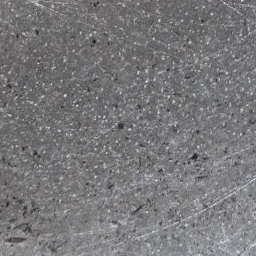

In [4]:
# Testing texture crops (uncomment debug print)
get_texture_crop('../data/textures/', size=input_size, debug=True)

[(25, 25), (230, 25), (25, 230), (230, 230)]
[[0.09765625, 0.09765625], [0.8984375, 0.09765625], [0.09765625, 0.8984375], [0.8984375, 0.8984375]]
(4, 256, 256)
(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


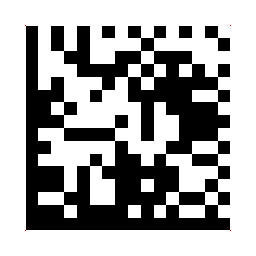

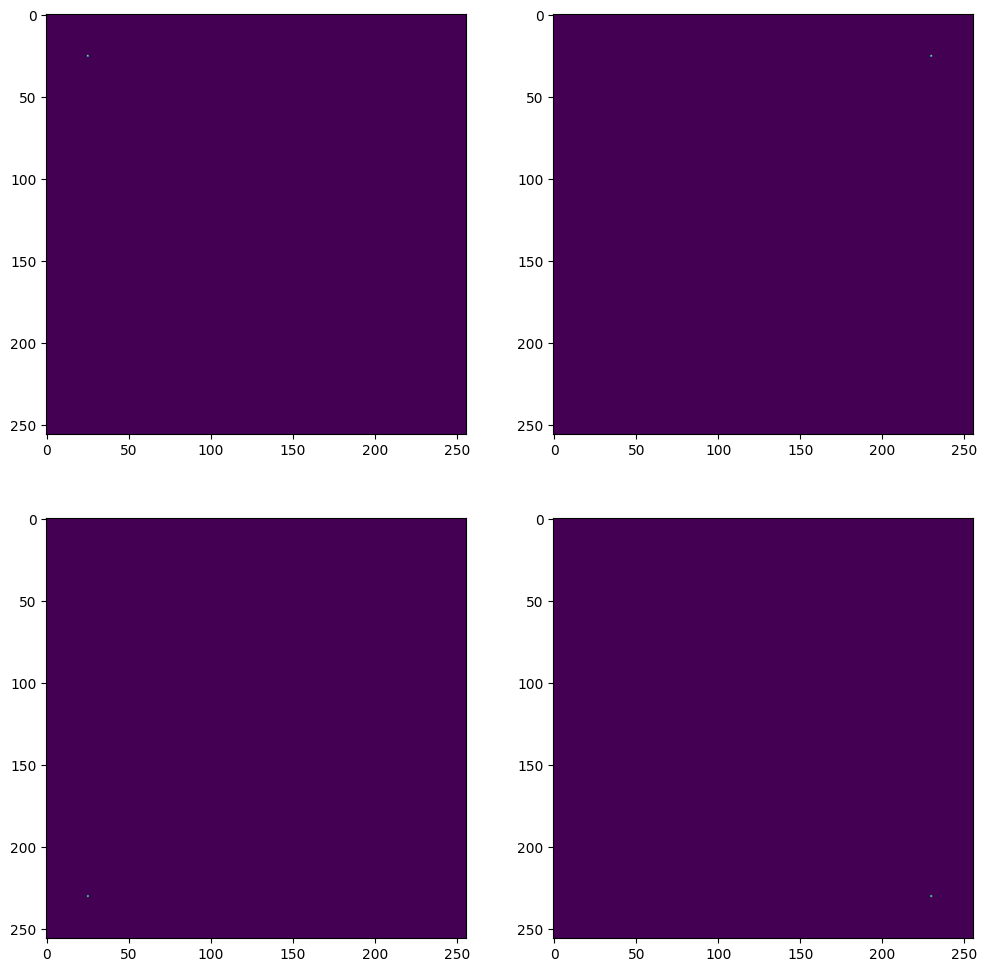

In [5]:
# Testing functions
test = gen_string()
img = encode_image(test, dmc_size=input_size)
raw_coords, label_info, img = get_corner_coords(img, debug=True)
print(raw_coords)
print(label_info)
# heatmaps = get_heatmaps(img, raw_coords, heatmap_size=input_size, sigma=sigma, debug=True)
heatmaps = get_heatmaps_basic(img, raw_coords, heatmap_size=input_size, debug=True)
print(heatmaps.shape)
print(heatmaps[0].shape)
print(heatmaps[0])

# Display image
display(img)

# Display heatmaps
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    heatmap = heatmaps[i]
    # scale up to input size
    heatmap = cv2.resize(heatmap, (input_size, input_size))
    plt.imshow(heatmap)
plt.show()

In [6]:
def gen_save(type, input_size):
    '''Generates a random serial number, encodes it into a DMC image, and saves it to train/val/test folders'''

    to_encode = gen_string()
    img = encode_image(to_encode, dmc_size=input_size)

    # Get corner values
    raw_coords, label_info, img = get_corner_coords(img)

    # Debug print
    if (0, 0) in raw_coords:
        print(raw_coords)
        error

    # Get heatmaps (basic - single point as we will create the actual heatmaps during augmentation)
    heatmaps = get_heatmaps_basic(img, raw_coords, heatmap_size=input_size, debug=False)

    # Convert heatmaps to tensor
    heatmaps = torch.tensor(heatmaps).float()

    # Normalize image
    img = np.array(img)
    img = img / 255
    img = torch.tensor(img).float()
    img = img.permute(2, 0, 1) # Change to having channel dim first

    # Generate random texture crop (size should match input for model)
    texture = get_texture_crop('../data/textures/', size=input_size)

    # Normalize texture
    texture = np.array(texture)
    texture = texture / 255
    texture = torch.tensor(texture).float()
    texture = texture.permute(2, 0, 1) # Change to having channel dim first

    # Combine image, texture, and heatmaps into single tensor
    img = torch.cat((img, texture, heatmaps), dim=0)

    # Save image texture heatmaps wombo combo
    torch.save(img, f'../data/hourglass_localization_rectification/{type}/{to_encode}.pt')

    return

def delete_old():
    '''Deletes all images and labels in train/val/test folders'''

    for folder in ['train', 'val', 'test']:
        for file in os.listdir(f'../data/hourglass_localization_rectification/{folder}'):
            os.remove(f'../data/hourglass_localization_rectification/{folder}/{file}')

    return

In [7]:
# Delete old synth data
delete_old()

In [8]:
# Generating train/val/test datasets
print(f'Generating {n_train} train images...')
for i in range(n_train - len(os.listdir('../data/hourglass_localization_rectification/train'))):
    gen_save('train', input_size=input_size)

print(f'Generating {n_val} val images...')
for i in range(n_val - len(os.listdir('../data/hourglass_localization_rectification/val'))):
    gen_save('val', input_size=input_size)

print(f'Generating {n_test} test images...')
for i in range(n_test - len(os.listdir('../data/hourglass_localization_rectification/test'))):
    gen_save('test', input_size=input_size)

Generating 800 train images...
Generating 100 val images...
Generating 100 test images...


In [9]:
# Test file
def load_test_file(debug=False):
    '''Loads a test file for inspection'''

    test_file = '../data/hourglass_localization_rectification/train/' + os.listdir('../data/hourglass_localization_rectification/train')[0]
    test_tensor = torch.load(test_file)

    print(test_file)
    return test_tensor
_ = load_test_file(debug=True)

../data/hourglass_localization_rectification/train/0A2P14096520027.pt


../data/hourglass_localization_rectification/train/0A2P14096520027.pt


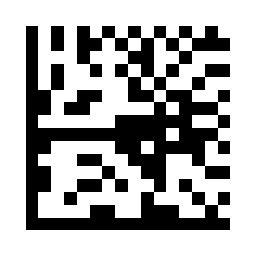

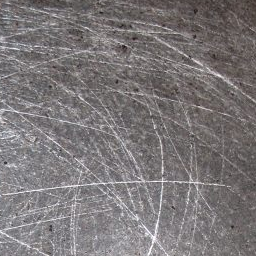

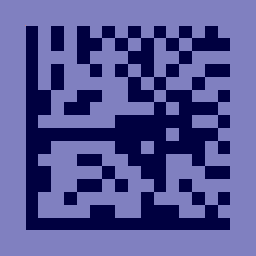

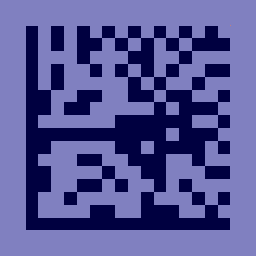

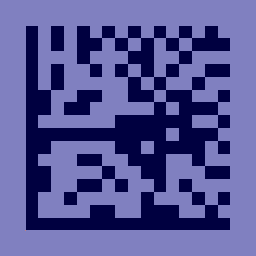

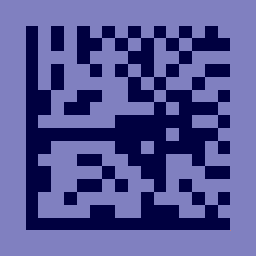

In [10]:
# Helper for presenting images / creating PIL images
def tensors2PIL(tensor, size, debug=False):
    # Move to CPU
    tensor = tensor.cpu()

    # Split into DMC and texture images
    dmc = tensor[:3].numpy()
    texture = tensor[3:6].numpy()
    heatmap = tensor[6:].numpy()

    # Multiply by 255 to convert to 0-255 range
    dmc = dmc * 255
    texture = texture * 255

    # Ensure no values are above 255
    dmc[dmc > 255] = 255
    texture[texture > 255] = 255

    # Convert to uint8
    dmc = dmc.astype(np.uint8)
    texture = texture.astype(np.uint8)

    # Reshape dmc to 3D
    dmc = dmc.reshape(3, size, size).transpose(1, 2, 0)

    # Reshape texture to 3D
    texture = texture.reshape(3, size, size).transpose(1, 2, 0)

    # Reshape heatmaps to 2D
    heatmaps = []
    for i in range(4):
        heatmaps.append(heatmap[i].reshape(size, size))

    # Convert to PIL images
    dmc = Image.fromarray(dmc).convert('L')
    texture = Image.fromarray(texture).convert('RGB')
    for idx, heatmap in enumerate(heatmaps):
        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
        dmc_tmp = cv2.cvtColor(np.array(dmc), cv2.COLOR_GRAY2RGB)
        overlay = cv2.addWeighted(dmc_tmp, 0.5, heatmap_colored, 0.5, 0) # Blend images
        heatmap_img = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        heatmaps[idx] = Image.fromarray(heatmap_img)

    if debug:
        display(dmc)
        display(texture)
        for heatmap in heatmaps:
            display(heatmap)

    return dmc, texture, heatmaps

test_tensor = load_test_file()
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A2P14096520027.pt


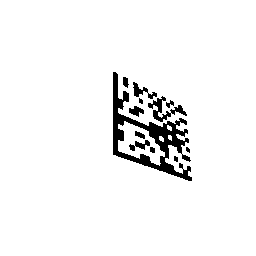

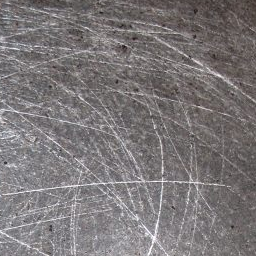

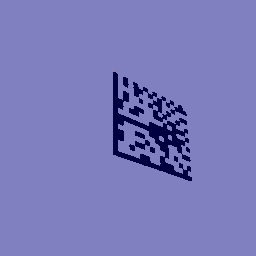

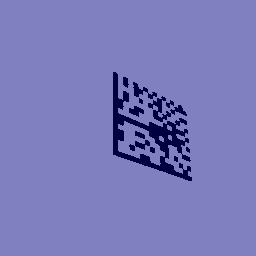

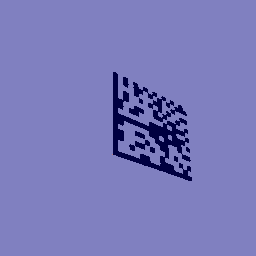

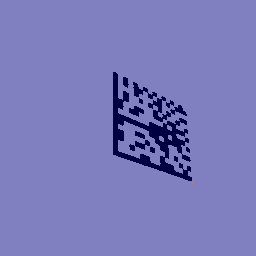

In [11]:
def flood_fill(tensor_image, x, y):
    '''Finds and fills all connected black pixels in image starting from x, y'''
    rows, cols = tensor_image.shape[-2], tensor_image.shape[-1]
    visited = set()
    stack = [(x, y)]

    connected_pixels = []

    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))

        # Ensure it's within bounds and is black
        if 0 <= cx < rows and 0 <= cy < cols and tensor_image[cx, cy] == 0:
            connected_pixels.append((cx, cy))

            # Add neighbors (if not at the edge of the image)
            if cx > 0:
                stack.append((cx-1, cy))
            if cx < rows-1:
                stack.append((cx+1, cy))
            if cy > 0:
                stack.append((cx, cy-1))
            if cy < cols-1:
                stack.append((cx, cy+1))
    
    for idx in connected_pixels:
        tensor_image[idx[0], idx[1]] = 1
    
    return tensor_image

def shape_transform(tensor):
    '''Applies random shape transformations to image'''
    generation_error = False

    # Split into DMC and heatmaps
    dmc = tensor[:3]
    heatmaps = tensor[6:]

    # Temporarily downsize dmc to 1 channel to allow for next steps (IMPORTANT: THIS WILL SUCK IF SHAPE TRANSFORM SOMEHOW GETS USED AFTER COLOR TRANSFORM)
    dmc = dmc[0]

    # Stacking tensors for easier processing
    batched = torch.stack((dmc, heatmaps[0], heatmaps[1], heatmaps[2], heatmaps[3]), dim=0)

    # First pad batched tensor to ensure corners are not near the edge
    batched = v2.functional.pad(batched, padding=100, fill=0, padding_mode='constant')

    # DEBUG 
    heatmaps = batched[1:]
    for i in range(4):
        brightest = heatmaps[i].max()
        torch_mask = torch.where(heatmaps[i] == brightest, torch.tensor(1.0), torch.tensor(0.0))
        if generation_error == False and torch_mask.nonzero()[0].tolist() == [0, 0]:
            print('generation_error - before transforms')
            generation_error = True
        heatmaps[i] = torch_mask

    # Applying transformations to all tensors
    transforms = v2.Compose([
        # v2.RandomRotation(random.randrange(0, 360),
        #                   interpolation=Image.BILINEAR,
        #                   expand=True),
        # v2.Pad(padding=10, fill=255, padding_mode='constant'), # Padding ensures corners are not near the edge
        v2.RandomPerspective(distortion_scale=0.5,
                             p=0.5,
                             interpolation=Image.BILINEAR,
                            #  fill=255,
                             ),
        # v2.Pad(padding=100, fill=255, padding_mode='constant'), # Padding ensures corners are not near the edge
        v2.RandomAffine(degrees=0,
                        # Random "squish" on x and y axis
                        shear=(-random.randrange(10,20), random.randrange(10,20), -random.randrange(10,20), random.randrange(10,20)),
                        interpolation=Image.BILINEAR,
                        # fill=255,
                        ),
        # v2.Pad(padding=100, fill=255, padding_mode='constant'), # Padding ensures corners are not near the edge
    ])
    batched = transforms(batched)

    # Resize all to original size
    dmc_width, dmc_height = dmc.shape[-1], dmc.shape[-2]
    batched = v2.functional.resize(batched, (dmc_height, dmc_width), interpolation=Image.BILINEAR)

    # Binarize dmc
    dmc = batched[0]
    dmc = torch.where(dmc > 0.5, torch.tensor(1.0), torch.tensor(0.0))

    # DEBUG 
    heatmaps = batched[1:]
    for i in range(4):
        brightest = heatmaps[i].max()
        torch_mask = torch.where(heatmaps[i] == brightest, torch.tensor(1.0), torch.tensor(0.0))
        if generation_error == False and torch_mask.nonzero()[0].tolist() == [0, 0]:
            print('generation_error - before paintbucket')
            generation_error = True
        heatmaps[i] = torch_mask

    # Fill outer black areas of dmc with white
    dmc = flood_fill(dmc, 0, 0)
    dmc = flood_fill(dmc, 0, dmc.shape[-1]-1)
    dmc = flood_fill(dmc, dmc.shape[-2]-1, 0)
    dmc = flood_fill(dmc, dmc.shape[-2]-1, dmc.shape[-1]-1)

    # Split back into DMC and heatmaps
    dmc = dmc.unsqueeze(0)
    heatmaps = batched[1:]

    # Binarize heatmaps so that brightest pixel is 1 and rest are 0
    for i in range(4):
        brightest = heatmaps[i].max()
        torch_mask = torch.where(heatmaps[i] == brightest, torch.tensor(1.0), torch.tensor(0.0))
        if generation_error == False and torch_mask.nonzero()[0].tolist() == [0, 0]:
            print('generation_error - after paintbucket')
        heatmaps[i] = torch_mask

    # Add back color channels to DMC
    dmc = torch.cat((dmc, dmc, dmc), dim=0)

    return dmc, heatmaps, generation_error

test_tensor = load_test_file()
test_tensor[:3], test_tensor[6:], generation_error = shape_transform(test_tensor)
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A2P14096520027.pt


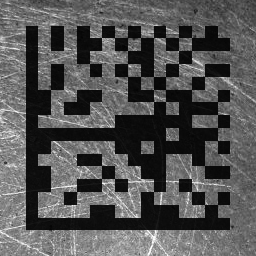

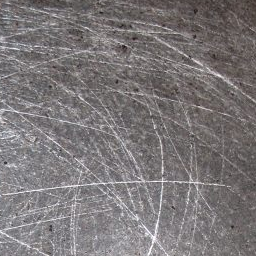

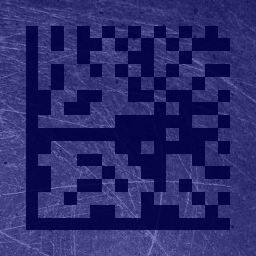

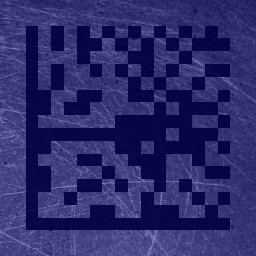

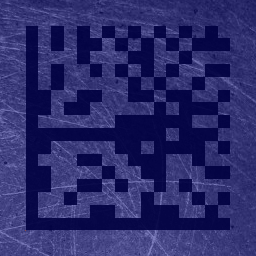

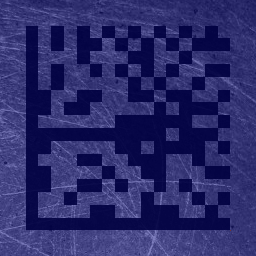

In [12]:
def combine_images(tensor):
    '''Combines DMC and texture tensors into one tensor'''
    dmc = tensor[:3].unsqueeze(0)
    texture = tensor[3:6].unsqueeze(0)

    # Increment black pixel intensity of DMC randomly
    increment = random.uniform(0.1, 0.5)
    dmc = torch.where(dmc < 0.5, dmc + increment, dmc)

    # Multiply DMC onto each texture channel
    texture = torch.mul(texture, dmc)

    # Remove batch dimension
    texture = texture.squeeze(0)

    return texture

test_tensor = load_test_file()
test_tensor[:3] = combine_images(test_tensor)
combined_dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A2P14096520027.pt


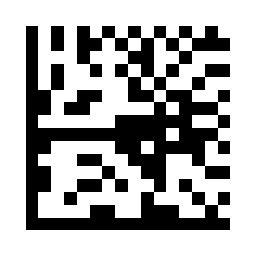

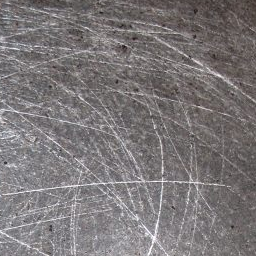

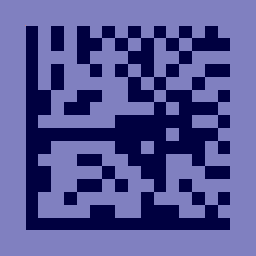

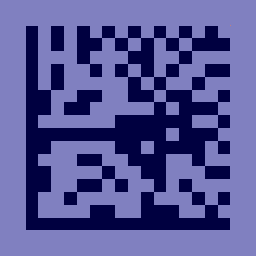

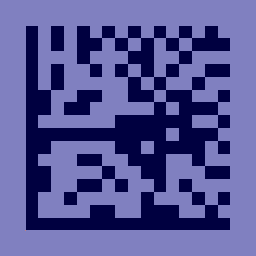

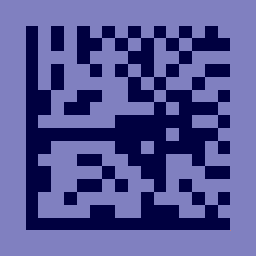

In [13]:
def color_transform(tensor):
    '''Applies random color transformations to image'''

    # Unsqueeze tensor to add batch dimension
    tensor = tensor.unsqueeze(0)

    # Random kernel size for gaussian blur
    kernel_size = random.choice([7, 9, 11])
    sharpness = random.uniform(0.5, 1.5)

    # transforms = v2.Compose([
    #     # v2.ColorJitter(brightness = (0.5, 1.5),
    #     #                contrast   = (0.5, 1.5),
    #     #                saturation = (0.5, 1.5),
    #     #                hue        = (-0.5, 0.5),
    #     #                ),
    #     # v2.RandomChannelPermutation(),
    #     v2.RandomPhotometricDistort(brightness = (0.5, 1.5),
    #                                 contrast   = (0.5, 1.5),
    #                                 saturation = (0.5, 1.5),
    #                                 hue        = (-0.5, 0.5),
    #                                 ),
    #     v2.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 100.0)), # chance to blur a lot or a little - mostly an ok amount
    #     # v2.GaussianNoise(), # not implemented for PIL images
    #     # v2.RandomInvert(0.2), # lower chance of inversion # apply to code not background
    #     # v2.RandomPosterize(8),
    #     # v2.RandomSolarize(0.5, 0.5),
    #     v2.RandomAdjustSharpness(sharpness, 0.5),
    #     # v2.RandomAutocontrast(),
    #     # v2.RandomEqualize(0.2), # lower chance of equalization
    # ])

    # Dummy transform for testing
    transforms = v2.Compose([
        v2.Pad(padding=0)
    ])

    tensor = transforms(tensor)

    # Remove batch dimension
    tensor = tensor.squeeze(0)

    return tensor

# Testing color_transform
test_tensor = load_test_file()
test_tensor[:3] = color_transform(test_tensor[:3])
test_tensor[3:6] = color_transform(test_tensor[3:6])
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A2P14096520027.pt
DMC TEXTURE PAIR
SHAPE TRANSFORM
COMBINE IMAGES
COLOR TRANSFORM
FINAL SIZES
torch.Size([3, 256, 256])
torch.Size([4, 256, 256])


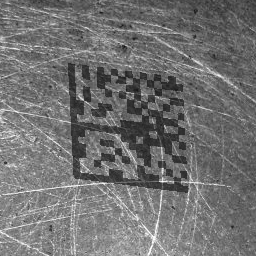

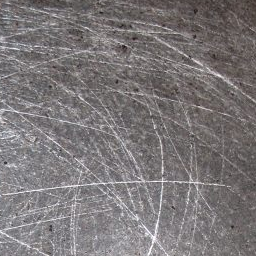

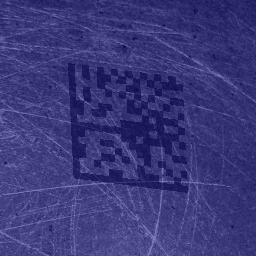

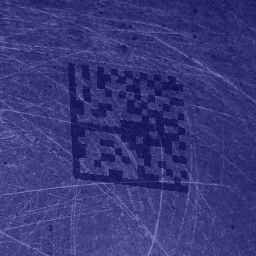

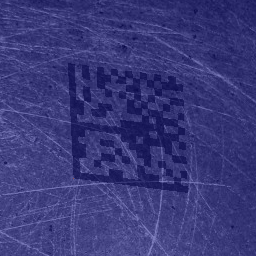

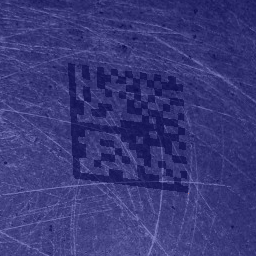

In [14]:
# Testing all transforms
test_tensor = load_test_file()

print('DMC TEXTURE PAIR')
# dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('SHAPE TRANSFORM')
test_tensor[:3], test_tensor[6:], generation_error = shape_transform(test_tensor)
# dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

if generation_error:
    print('GENERATION ERROR')

print('COMBINE IMAGES')
dmc = combine_images(test_tensor)
# dmc_img, texture_img, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('COLOR TRANSFORM')
dmc = color_transform(dmc)

# Overwrite for the sake of seeing
test_tensor[:3] = dmc
print('FINAL SIZES')
print(dmc.shape)
print(test_tensor[6:].shape)
dmc_img, texture_img, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

In [15]:
# Helper function for resizing heatmaps
def resize_heatmaps(heatmaps, size):
    '''Resizes heatmaps to given size'''
    new_heatmaps = np.zeros((4, size, size))
    for i in range(4):
        # heatmap = np.array(heatmaps[i])
        # # We use an interpolation that keeps the heatmap shape best
        # heatmap = cv2.resize(heatmap, (size, size), interpolation=cv2.INTER_AREA)
        # new_heatmaps[i] = heatmap

        # Find proportionally where the max value is in the heatmap
        y, x = np.unravel_index(np.argmax(heatmaps[i]), heatmaps[i].shape)
        y = int(y * size / heatmaps[i].shape[0])
        x = int(x * size / heatmaps[i].shape[1])

        # Create new heatmap
        heatmap = np.zeros((size, size))
        heatmap[y, x] = 1

        new_heatmaps[i] = heatmap

    # Convert to tensor
    new_heatmaps = torch.tensor(new_heatmaps).float()

    return new_heatmaps

# Actually creating the heatmaps from the pixel heatmaps
def create_heatmap(heatmaps, size, sigma):
    '''Creates heatmaps from pixel heatmaps'''
    heatmaps_final = np.zeros((4, size, size))
    for idx, pixel_heatmap in enumerate(heatmaps):
        # Center of keypoint
        y, x = np.unravel_index(np.argmax(pixel_heatmap), pixel_heatmap.shape)

        # Fill heatmap with gaussian distribution
        heatmap = np.zeros((size, size))
        for y2 in range(size):
            for x2 in range(size):
                heatmap[y2, x2] = np.exp(-((x2 - x)**2 + (y2 - y)**2) / (2 * sigma**2))  # Sigma = std of the Gaussian distribution

        # Add heatmap to heatmaps
        heatmaps_final[idx] = heatmap

    # Convert to tensor
    heatmaps_final = torch.tensor(heatmaps_final).float()

    return heatmaps_final

torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 64, 64])


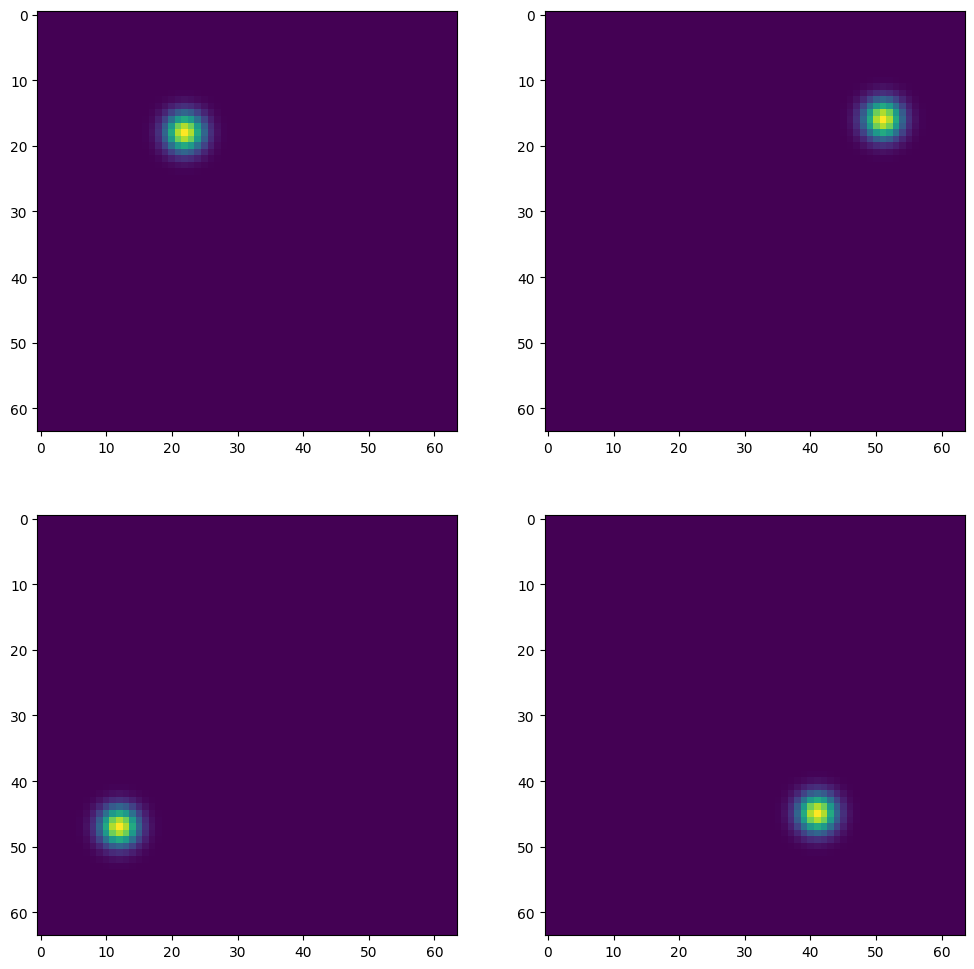

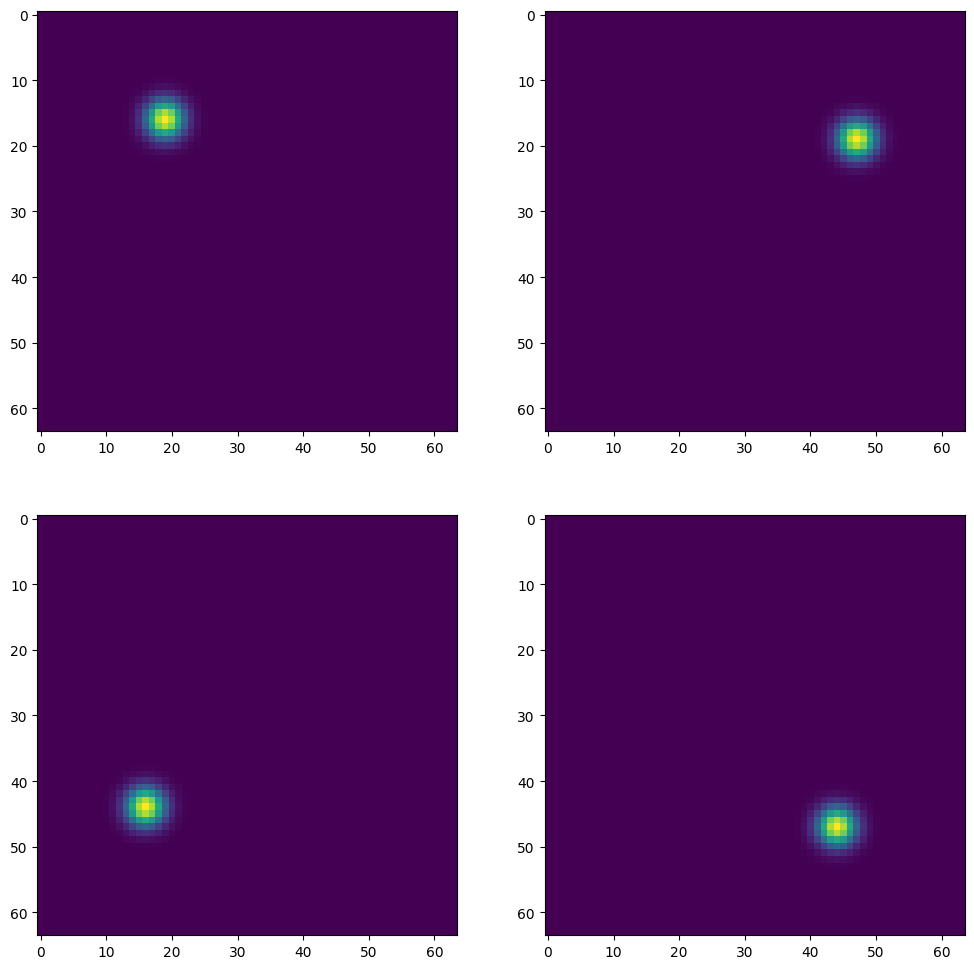

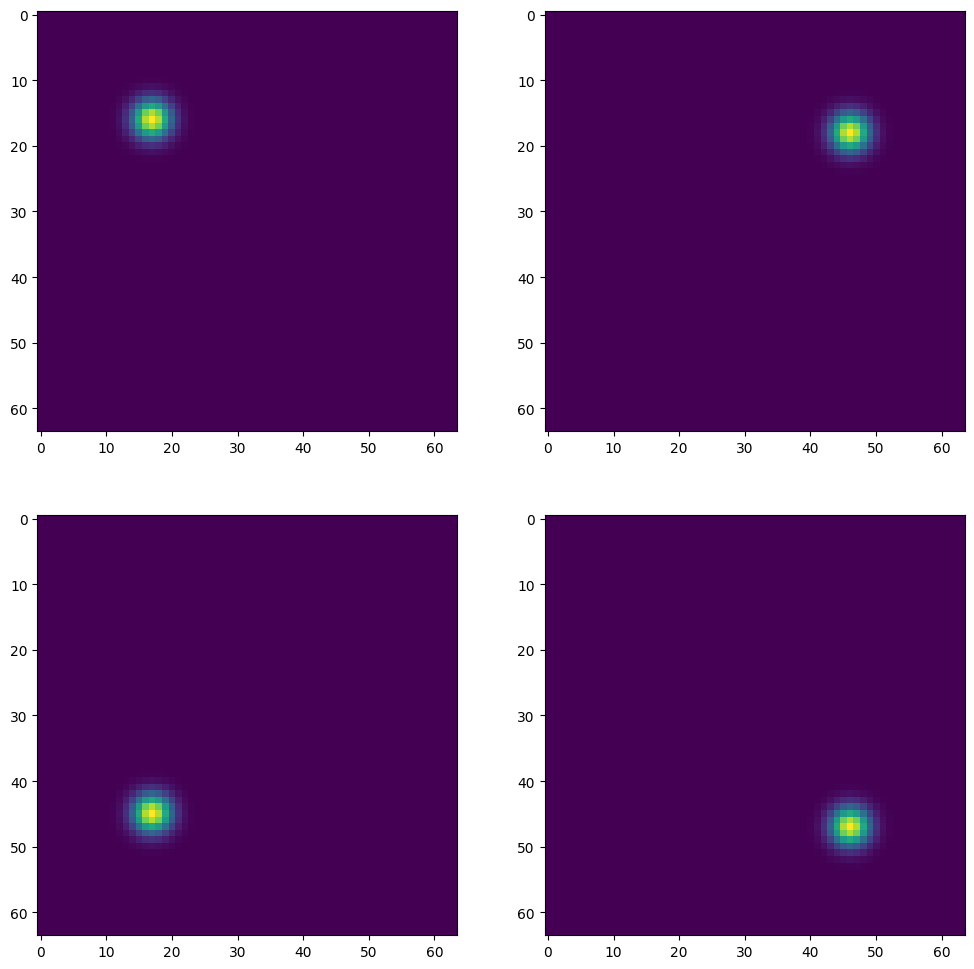

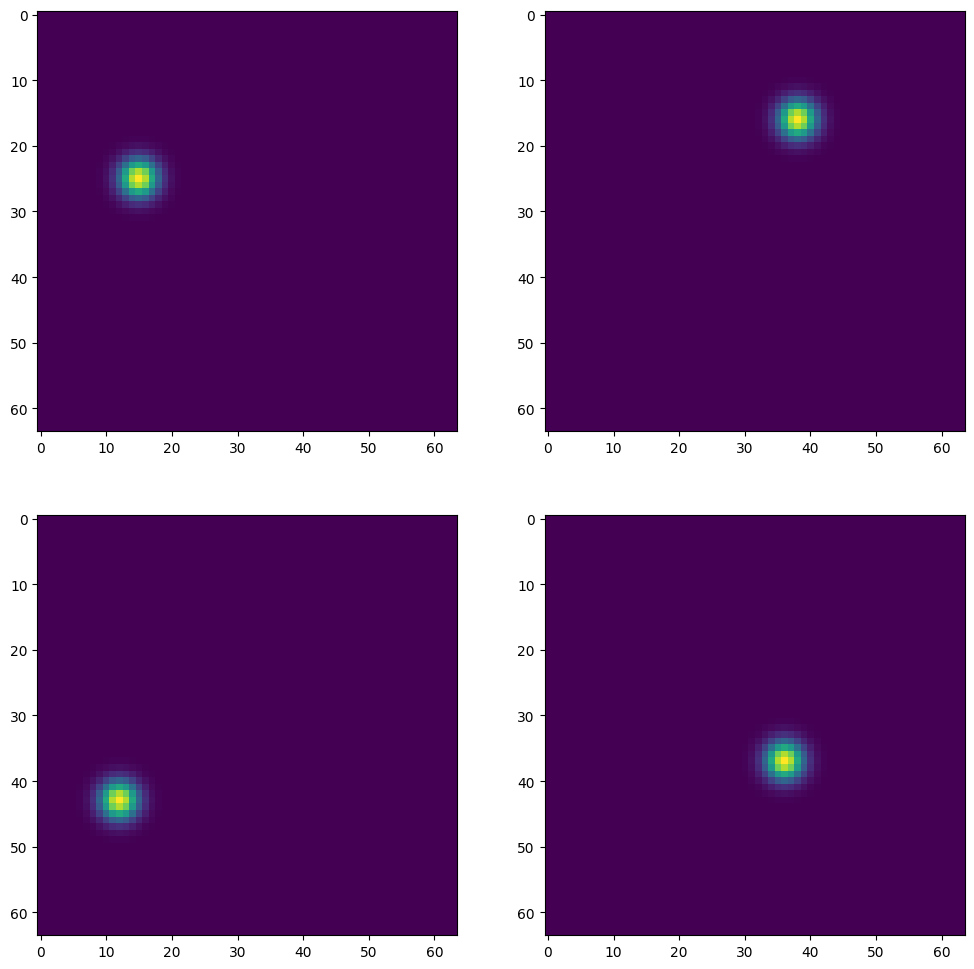

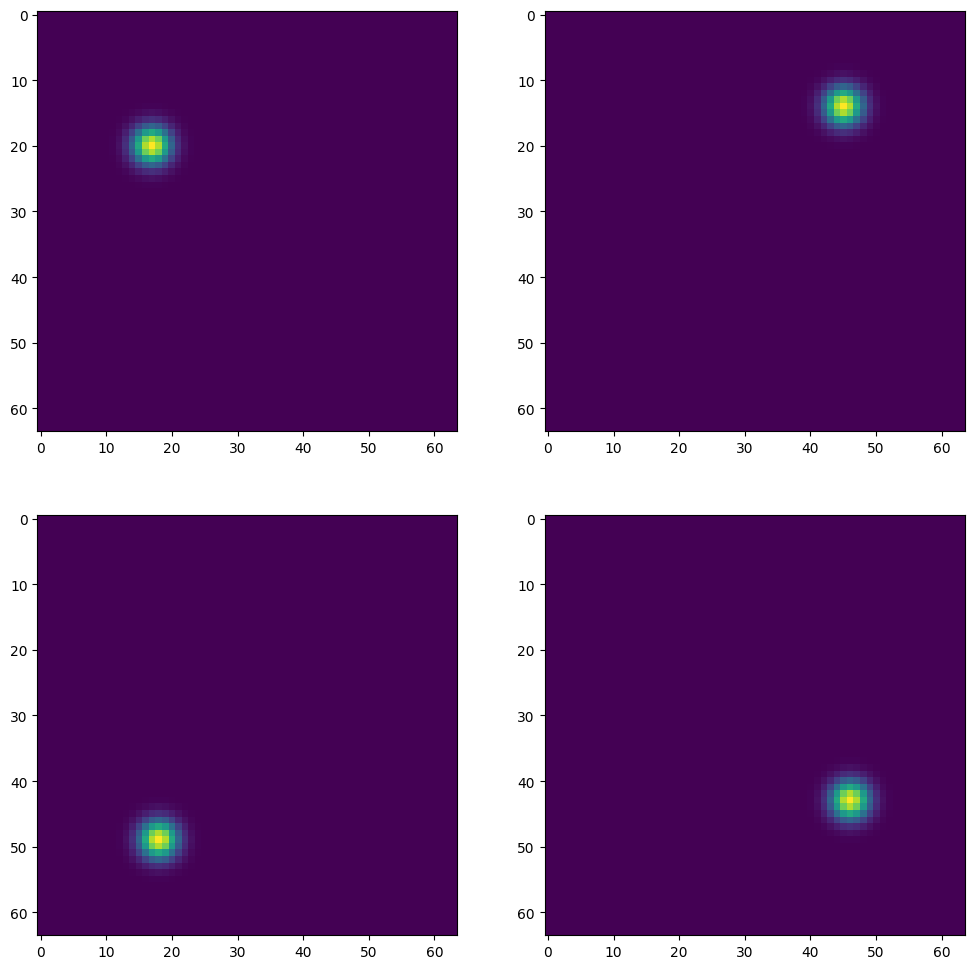

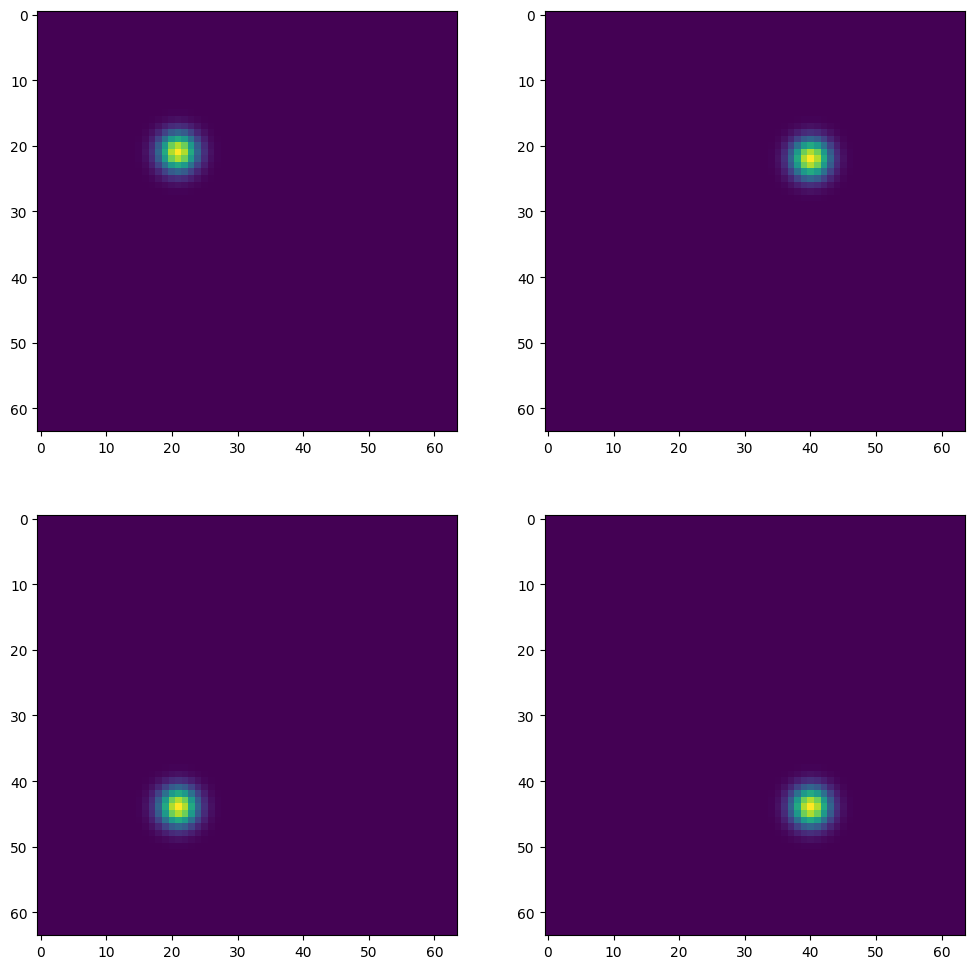

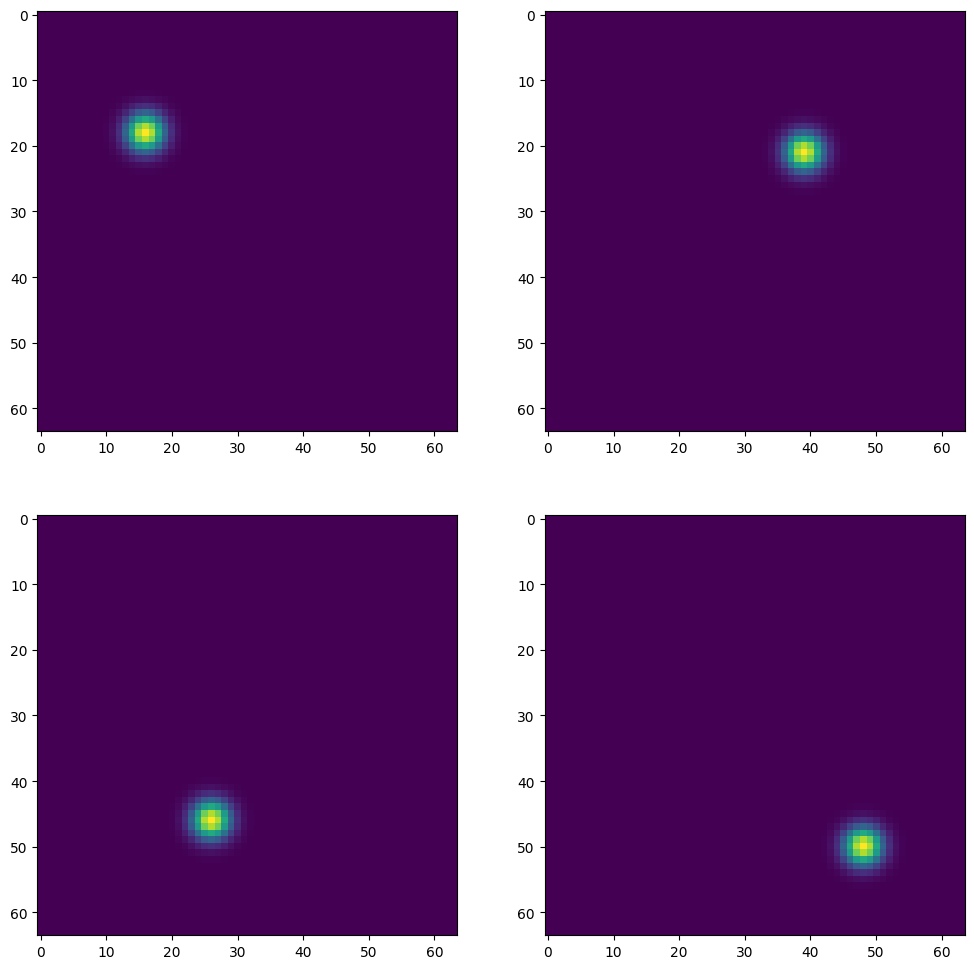

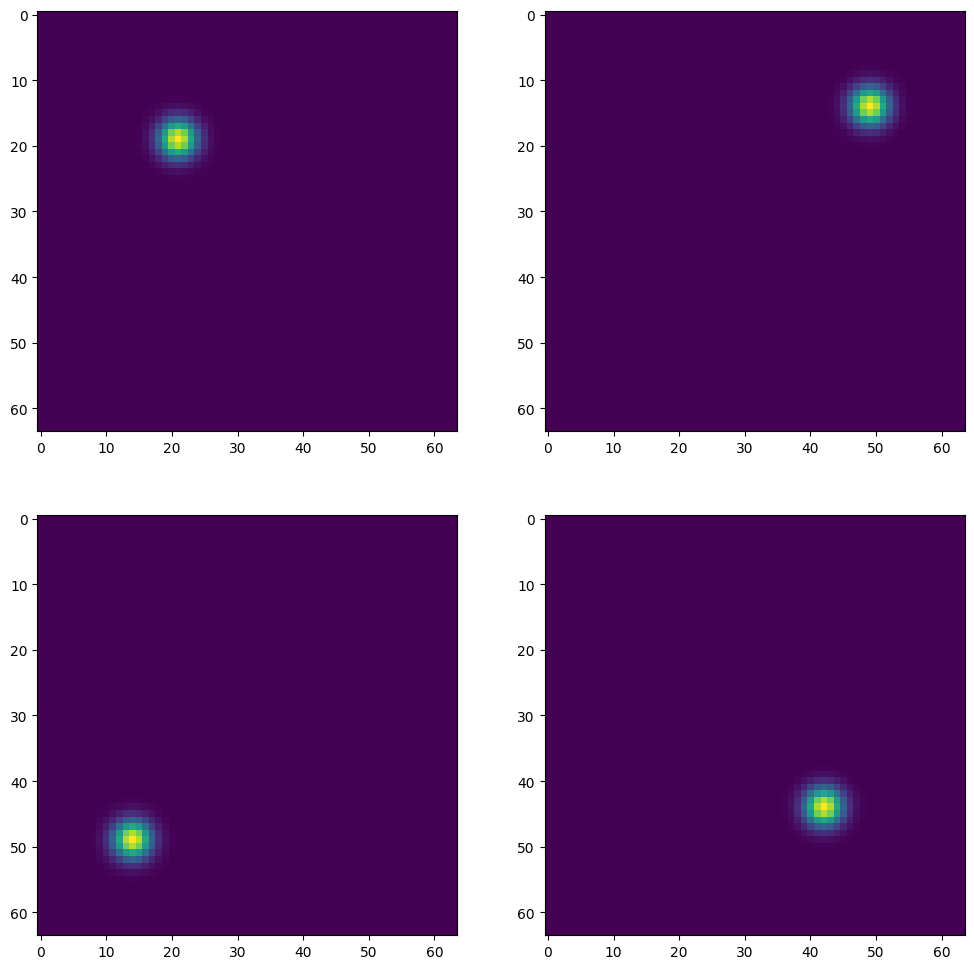

In [16]:
# Dataloader
class DMCDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, idx):
        # Load the tensor containing dmc, texture, and heatmaps
        # tensor = torch.load(f'{self.image_dir}/{self.files[idx]}')

        # Shape transform dmc and heatmaps
        generation_error = True
        count = 0
        while generation_error == True:
            if count > 0:
                print('Trying again...')

            # Load the tensor containing dmc, texture, and heatmaps
            tensor = torch.load(f'{self.image_dir}/{self.files[idx]}')
            tensor[:3], tensor[6:], generation_error = shape_transform(tensor)
            count += 1
        if count > 1:
            print('Fixed!')

        # Combine dmc and texture pair
        dmc = combine_images(tensor)

        # Color transform dmc
        dmc = color_transform(dmc)

        # Resize pixel heatmaps to output size
        heatmaps = resize_heatmaps(tensor[6:], output_size)

        # Create actual heatmaps from binarized heatmaps
        heatmaps = create_heatmap(heatmaps, output_size, sigma)

        return dmc, heatmaps

train_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/train',
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

# Testing dataloader
for dmc, heatmaps in train_loader:
    print(dmc.shape)
    print(heatmaps.shape)

    # Display dmc and heatmaps
    for i in range(dmc.shape[0]):
        
        plt.figure(figsize=(12, 12))
        for j in range(4):
            plt.subplot(2, 2, j+1)
            plt.imshow(heatmaps[i, j])
        plt.show()
    break

In [17]:
val_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/val',
)

val_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

test_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/test',
)

test_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
)

# Stacked Hourglass Setup

In [18]:
# Example usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=4,
)

for images, heatmaps in train_loader:
    print(images.shape)
    print(heatmaps.shape)
    output = model(images)
    print(output.shape) # Expected: (8, 4, H, W) representing 4 heatmaps per image
    break
print(output)

torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 64, 64])
torch.Size([8, 4, 64, 64])
tensor([[[[2069.7180, 2069.5730, 2066.3540,  ..., 1821.9634, 1820.2498,
           1821.1633],
          [2070.1296, 2069.8987, 2066.6318,  ..., 1822.1766, 1820.4313,
           1819.9573],
          [2070.7576, 2070.0566, 2065.6992,  ..., 1821.5215, 1819.4806,
           1819.3650],
          ...,
          [2681.3694, 2681.4487, 2678.4980,  ..., 1863.8611, 1863.8087,
           1863.4719],
          [2682.6902, 2682.3459, 2680.9612,  ..., 1865.4614, 1867.1902,
           1866.7437],
          [2683.1731, 2683.2473, 2682.7747,  ..., 1867.2166, 1869.4752,
           1867.4355]],

         [[2744.5415, 2744.7258, 2745.1631,  ..., 2726.1528, 2730.1265,
           2730.0476],
          [2744.8828, 2746.4546, 2747.3438,  ..., 2728.4849, 2732.5732,
           2731.7598],
          [2744.6304, 2746.2341, 2746.3394,  ..., 2725.5898, 2729.2864,
           2728.7844],
          ...,
          [3002.5464, 3003.687

(4, 64, 64)


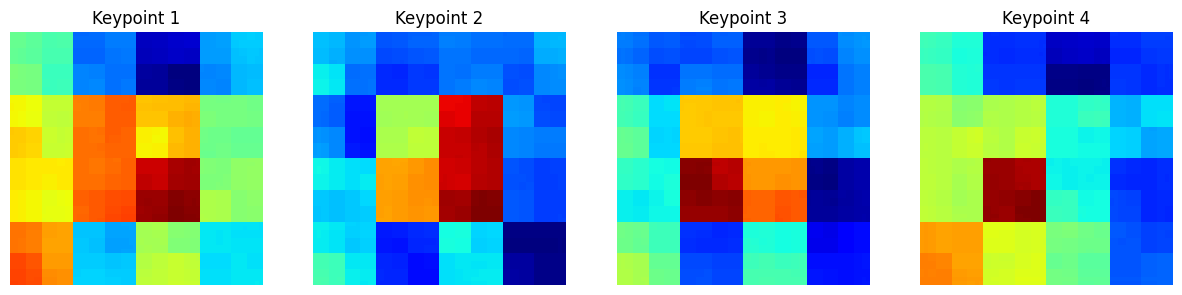

In [19]:
# Convert tensor to numpy for visualization
heatmaps = output[0].detach().cpu().numpy()  # Shape: (4, H, W)
print(heatmaps.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(heatmaps[i], cmap='jet')
    axes[i].set_title(f'Keypoint {i+1}')
    axes[i].axis('off')

plt.show()

In [20]:
def extract_keypoints(heatmaps, input_size, output_size):
    scale = input_size / output_size  # Scale factor to match original resolution
    keypoints = []
    for i in range(heatmaps.shape[0]):  # Iterate over keypoint heatmaps
        hmap = heatmaps[i]
        y, x = np.unravel_index(np.argmax(hmap), hmap.shape)  # Get max index
        keypoints.append((int(x * scale), int(y * scale)))  # Scale keypoints
    return keypoints

def heatmap_viz(image, keypoints, heatmaps, alpha=0.5):
    # Combined figure
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # Original image with keypoints
    image_kp = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert for OpenCV
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)] # Colors are blue, green, red, yellow (BGR)
    for i, (x, y) in enumerate(keypoints):
        cv2.circle(image_kp, (x, y), 5, colors[i], -1)  # Draw colored circle
    axes[0].imshow(cv2.cvtColor(image_kp, cv2.COLOR_BGR2RGB))
    axes[0].axis("off")
    axes[0].set_title("Image")

    # Heatmaps
    for i, heatmap in enumerate(heatmaps):
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to input image size
        heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())  # Normalize
        heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
        overlay = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)  # Blend images
        axes[i+1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[i+1].axis("off")

        if i == 0:
            axes[i+1].set_title("Heatmap (blue)")
        elif i == 1:
            axes[i+1].set_title("Heatmap (green)")
        elif i == 2:
            axes[i+1].set_title("Heatmap (red)")
        elif i == 3:
            axes[i+1].set_title("Heatmap (yellow)")
    
    plt.show()

(4, 64, 64)
Predicted keypoints: [(136, 132), (172, 228), (16, 0), (220, 160)]


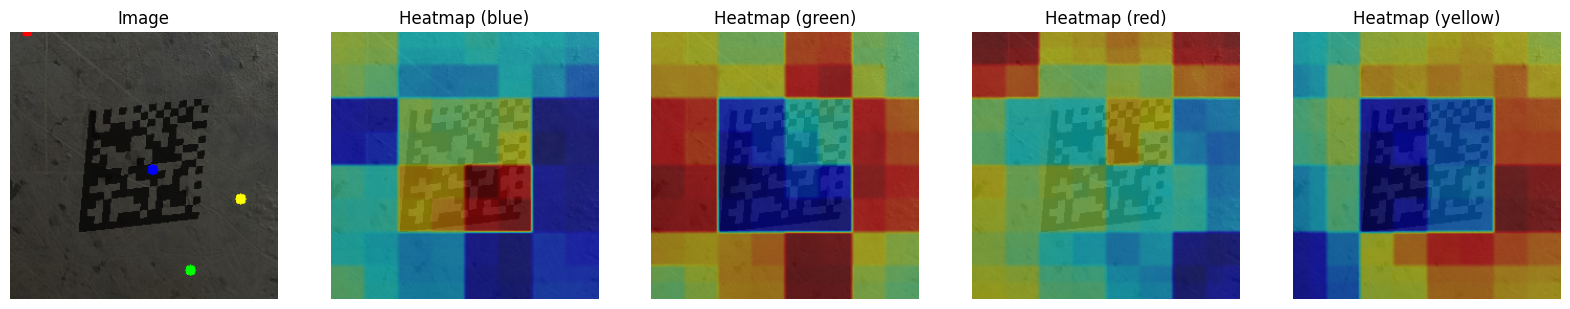

In [21]:
# Example vizualization usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=4,
)

for images, labels in train_loader:
    output = model(images)
    break

heatmaps = output[0].detach().cpu().numpy()  # Convert tensor to numpy
print(heatmaps.shape)
keypoints = extract_keypoints(heatmaps, input_size=input_size, output_size=output_size)
print('Predicted keypoints:', keypoints)

img = images[0].permute(1, 2, 0).numpy() * 255
img = img.astype(np.uint8) # Convert to ints only
heatmap_viz(img, keypoints, heatmaps)

(4, 64, 64)
True keypoints: [(68, 84), (184, 52), (68, 200), (184, 168)]


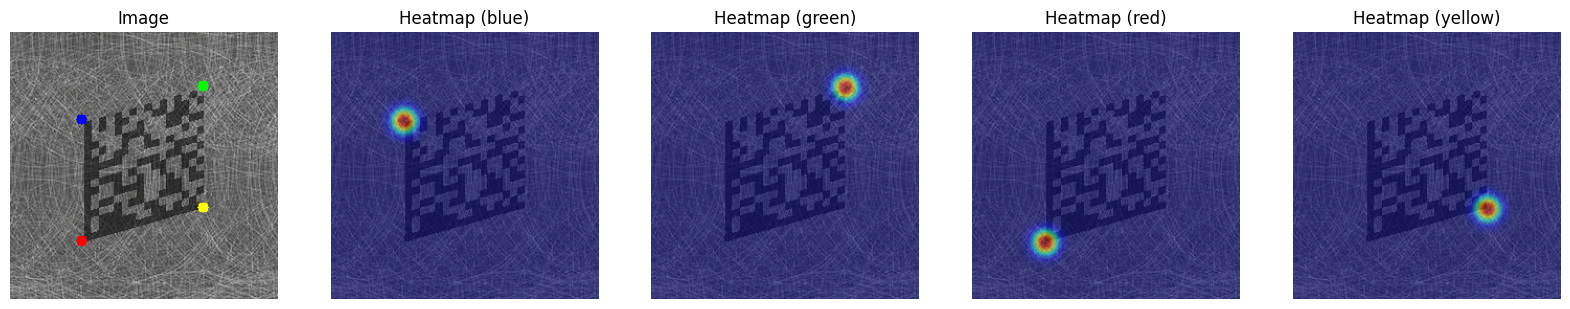

(4, 64, 64)
True keypoints: [(104, 80), (188, 100), (76, 148), (172, 172)]


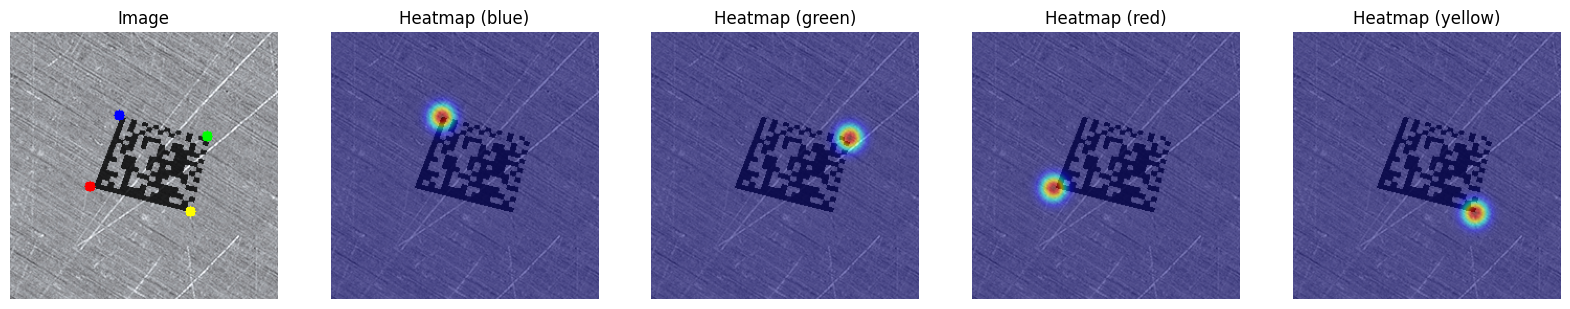

(4, 64, 64)
True keypoints: [(72, 64), (188, 72), (64, 180), (180, 188)]


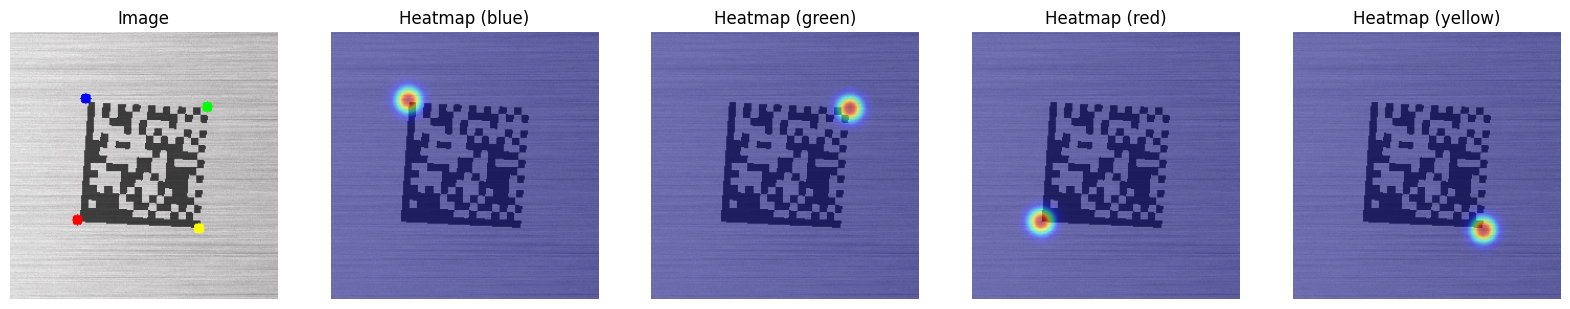

(4, 64, 64)
True keypoints: [(76, 80), (156, 76), (88, 176), (160, 168)]


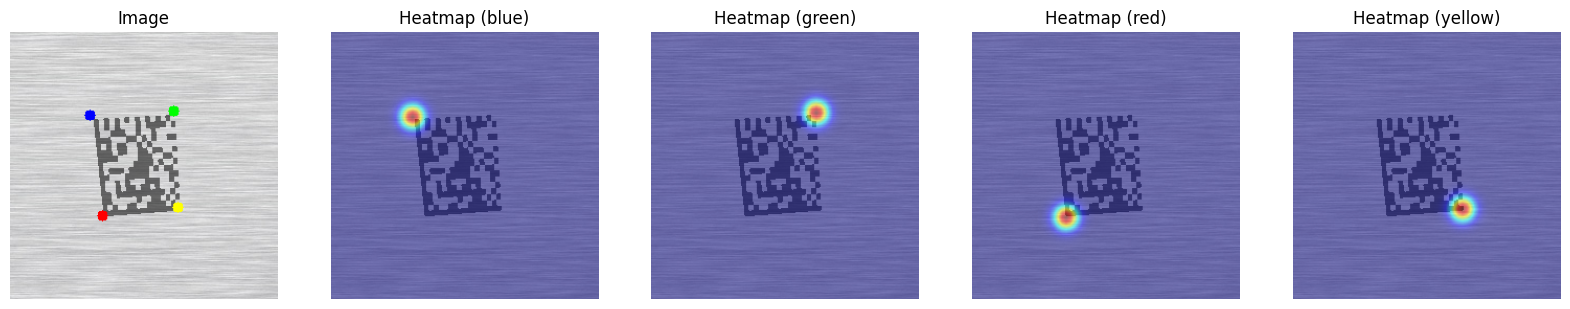

(4, 64, 64)
True keypoints: [(56, 96), (152, 108), (76, 184), (172, 196)]


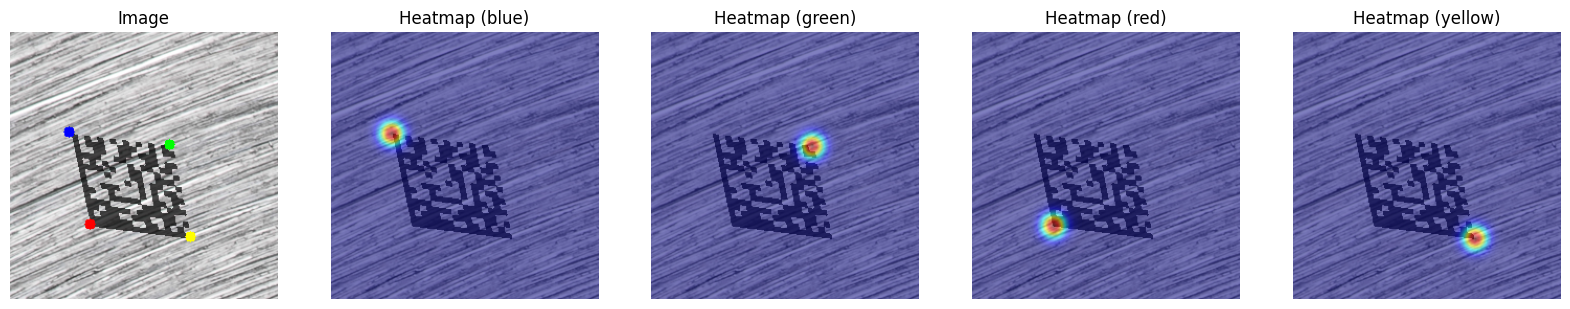

(4, 64, 64)
True keypoints: [(68, 112), (160, 112), (96, 184), (176, 184)]


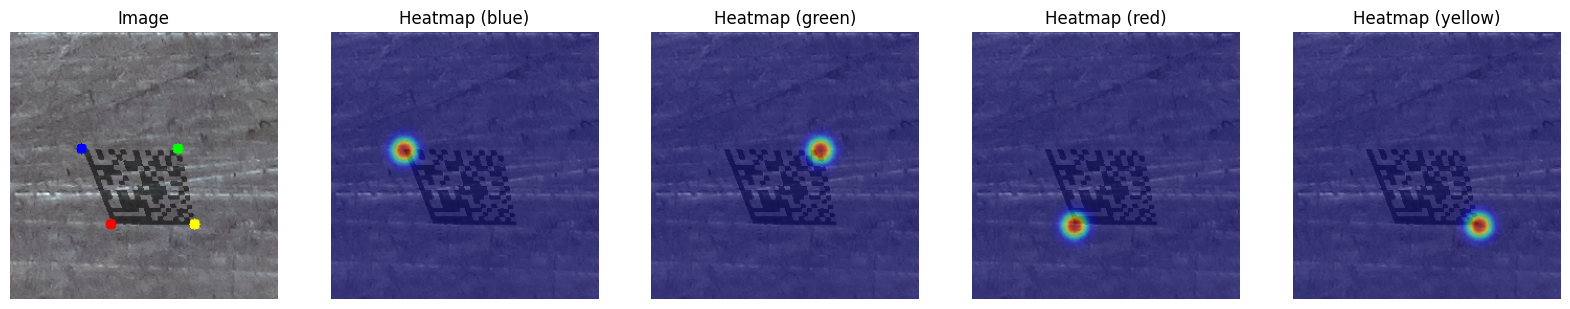

(4, 64, 64)
True keypoints: [(84, 68), (200, 68), (52, 184), (168, 184)]


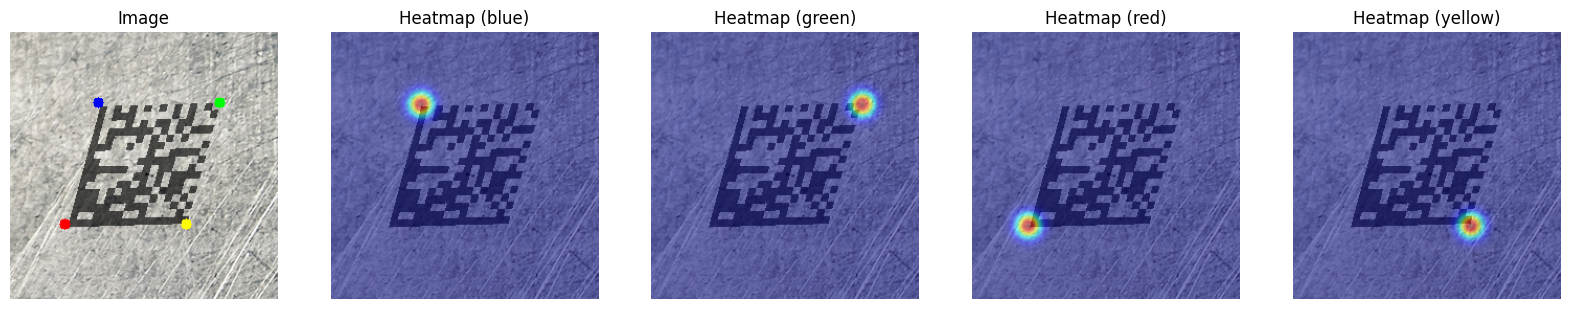

(4, 64, 64)
True keypoints: [(72, 96), (176, 92), (64, 172), (172, 172)]


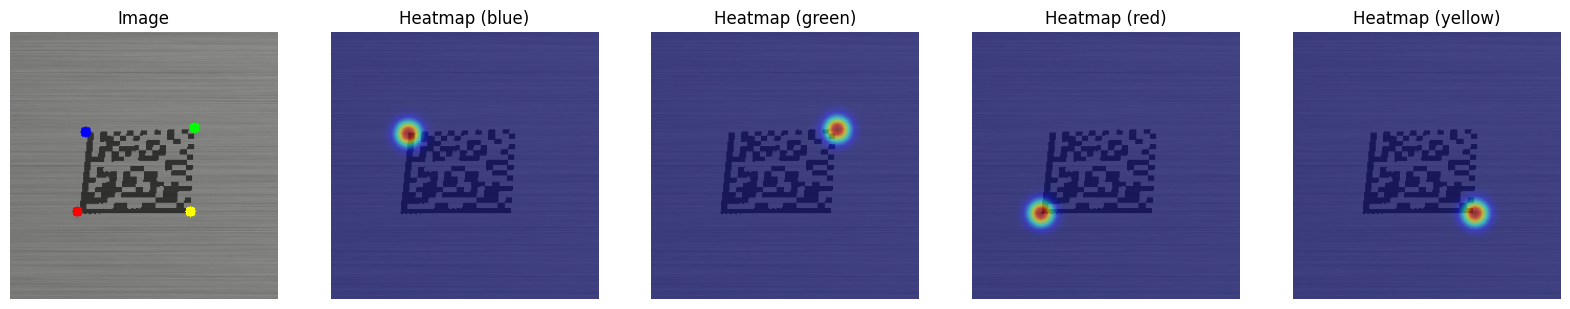

In [22]:
# Example vizualization of true keypoints and heatmaps
for images, labels in train_loader:
    for i in range(images.shape[0]):
        image = images[i].permute(1, 2, 0).numpy() * 255
        image = image.astype(np.uint8) # Convert to ints only

        heatmaps = labels[i].detach().cpu().numpy()  # Convert tensor to numpy
        print(heatmaps.shape)
        keypoints = extract_keypoints(heatmaps, input_size=input_size, output_size=output_size)
        print('True keypoints:', keypoints)
        heatmap_viz(image, keypoints, heatmaps)
    break

# Model Training

In [23]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [24]:
def calculate_loss(output, heatmaps, power):
    '''Calculates the loss between predicted and target heatmaps'''
    # criterion = nn.MSELoss()
    # loss = criterion(output, heatmaps)

    # Loss calculation with power - the higher the power the more focus on high values
    loss = torch.mean((heatmaps - output)**2 ** power)

    return loss

In [25]:
# Output and Heatmaps with circle in the middle
output = torch.zeros((8, 4, 64, 64), device=device)
output[:, :, 32, 32] = 1
heatmaps = torch.zeros((8, 4, 64, 64), device=device)
heatmaps[:, :, 32, 32] = 0

# Calculate loss
loss = calculate_loss(output, heatmaps, power)
print(loss)

tensor(0.0002, device='cuda:0')


In [26]:
# Training function
def train_model(model, early_stopper, train_loader, val_loader, epochs=10, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = {'train': [], 'val': []} # Store losses

    lowest_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(epochs):
        model.train()

        train_loss = 0
        for images, heatmaps in train_loader:
            images, heatmaps = images.to(device), heatmaps.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Custom loss function
            loss = calculate_loss(outputs, heatmaps, power)

            # Backprop
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        losses['train'].append(train_loss/len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = calculate_loss(outputs, masks, power)

                val_loss += loss.item()

        losses['val'].append(val_loss/len(val_loader))

        # Keep best model based on validation loss
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict() # Save best model state

        # Early stopping if validation loss increases
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch+1}')
            break

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.5f}, Val Loss: {val_loss/len(val_loader):.5f}')

    print('Best epoch:', best_epoch+1)

    # Reload the best model weights
    model.load_state_dict(best_model_state)

    return model, losses, lowest_val_loss

In [27]:
def fancy_train_model():
    model = StackedHourglassNetwork(
        num_stacks=n_stacks,
        num_features=input_size,
        num_output_points=4,
        )

    print('Initial training...')
    early_stopper = EarlyStopper(patience=10, min_delta=0.001)
    model, losses, lowest_val_loss = train_model(model,
                                                 early_stopper,
                                                 train_loader,
                                                 val_loader,
                                                 epochs=100,
                                                 lr=0.001
                                                 )

    print('\nQuick training...')
    early_stopper = EarlyStopper(patience=10, min_delta=0.0001)
    model_tmp, losses_tmp, lowest_val_loss_tmp = train_model(model,
                                                             early_stopper,train_loader,
                                                             val_loader,
                                                             epochs=100,
                                                             lr=0.0001
                                                             )
    losses = {key: losses[key] + losses_tmp[key] for key in losses.keys()}
    if lowest_val_loss_tmp < lowest_val_loss:
        model = model_tmp
        lowest_val_loss = lowest_val_loss_tmp
        print('Model replaced!')

    print('\nTouch up training...')
    early_stopper = EarlyStopper(patience=10, min_delta=0.0001)
    model_tmp, losses_tmp, lowest_val_loss_tmp = train_model(model,
                                                             early_stopper,
                                                             train_loader,
                                                             val_loader,
                                                             epochs=100,
                                                             lr=0.00001
                                                             )
    losses = {key: losses[key] + losses_tmp[key] for key in losses.keys()}
    if lowest_val_loss_tmp < lowest_val_loss:
        model = model_tmp
        lowest_val_loss = lowest_val_loss_tmp
        print('Model replaced!')

    print('\nFinal training...')
    early_stopper = EarlyStopper(patience=10, min_delta=0.00001)
    model_tmp, losses_tmp, lowest_val_loss_tmp = train_model(model,
                                                             early_stopper,
                                                             train_loader,
                                                             val_loader,
                                                             epochs=100,
                                                             lr=0.000001
                                                             )
    losses = {key: losses[key] + losses_tmp[key] for key in losses.keys()}
    if lowest_val_loss_tmp < lowest_val_loss:
        model = model_tmp
        lowest_val_loss = lowest_val_loss_tmp
        print('Model replaced!')

    print('\nTraining complete!')

    return model, losses

In [28]:
# Most recent change: 8 stacks, weighted loss, fixed saving best model weights
model, losses = fancy_train_model()

Initial training...
Epoch 1/100, Train Loss: 1042453168577389.75000, Val Loss: 63204173531.42857
Epoch 2/100, Train Loss: 913858096566.85718, Val Loss: 670830495973376.00000
generation_error - before paintbucket
Trying again...
Fixed!
Epoch 3/100, Train Loss: 499904445878.85712, Val Loss: 3696438478116.57129
Epoch 4/100, Train Loss: 183573239808.00000, Val Loss: 43197761974.85714
Epoch 5/100, Train Loss: 111167622582.85715, Val Loss: 4528628534.85714
Epoch 6/100, Train Loss: 51852757357.71429, Val Loss: 40036684068.57143
Epoch 7/100, Train Loss: 28792488886.85714, Val Loss: 9107108425.14286
Epoch 8/100, Train Loss: 10115714633.14286, Val Loss: 1621104932.57143
Epoch 9/100, Train Loss: 3543891675.42857, Val Loss: 2811572406.85714
Epoch 10/100, Train Loss: 1479626642.28571, Val Loss: 6693663387.42857
Epoch 11/100, Train Loss: 879270509.71429, Val Loss: 5843998144.00000
Epoch 12/100, Train Loss: 631343254.85714, Val Loss: 10174738489.14286
Epoch 13/100, Train Loss: 284579691.42857, Val Lo

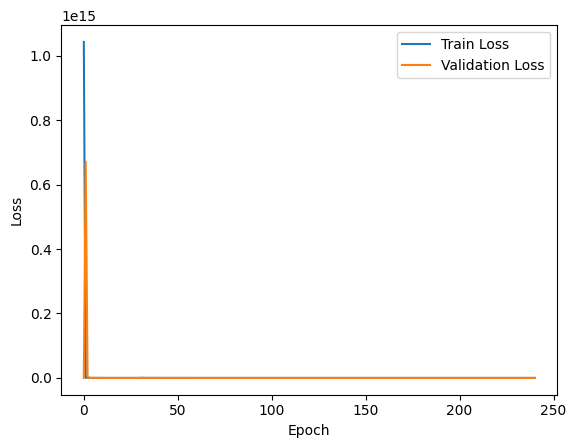

In [29]:
# Show training and validation losses
plt.plot(losses['train'], label='Train Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation

In [30]:
def evaluate_model(model, loader):
    model.eval()

    criterion = nn.MSELoss()

    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            count += 1
        
    print(f'Average loss: {total_loss/count:.4f}')

    return total_loss

# Normal trained

In [31]:
# Train loss
evaluate_model(model, train_loader)

Average loss: 90.3833


632.6833419799805

In [32]:
# Val loss
evaluate_model(model, val_loader)

Average loss: 93.7282


656.0972290039062

In [33]:
# Test loss
evaluate_model(model, test_loader)

Average loss: 93.2670


652.8687591552734

In [34]:
def compare_keypoints(model, loader):
    model.eval()

    with torch.no_grad():
        for images, true_heatmaps in loader:
            images, true_heatmaps = images.to(device), true_heatmaps
            break

        outputs = model(images)
        outputs = outputs.detach().cpu().numpy()
        true_heatmaps = true_heatmaps.numpy()

        for i in range(len(images)):
            img = images[i].permute(1, 2, 0).cpu().numpy() * 255
            img = img.astype(np.uint8) # Convert to ints only

            pred_keypoints = extract_keypoints(outputs[i], input_size=input_size, output_size=output_size)
            true_keypoints = extract_keypoints(true_heatmaps[i], input_size=input_size, output_size=output_size)

            print(f'Predicted keypoints: {pred_keypoints}')
            heatmap_viz(img, pred_keypoints, outputs[i])

            print(f'True keypoints: {true_keypoints}')
            heatmap_viz(img, true_keypoints, true_heatmaps[i])

            break

    return

## Train Print

Predicted keypoints: [(64, 184), (176, 220), (96, 212), (92, 4)]


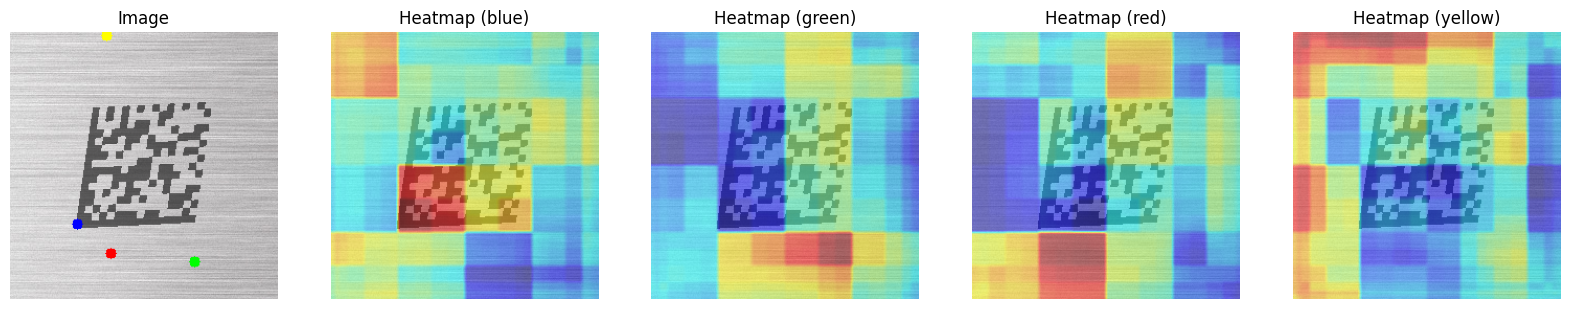

True keypoints: [(76, 72), (192, 64), (60, 188), (176, 180)]


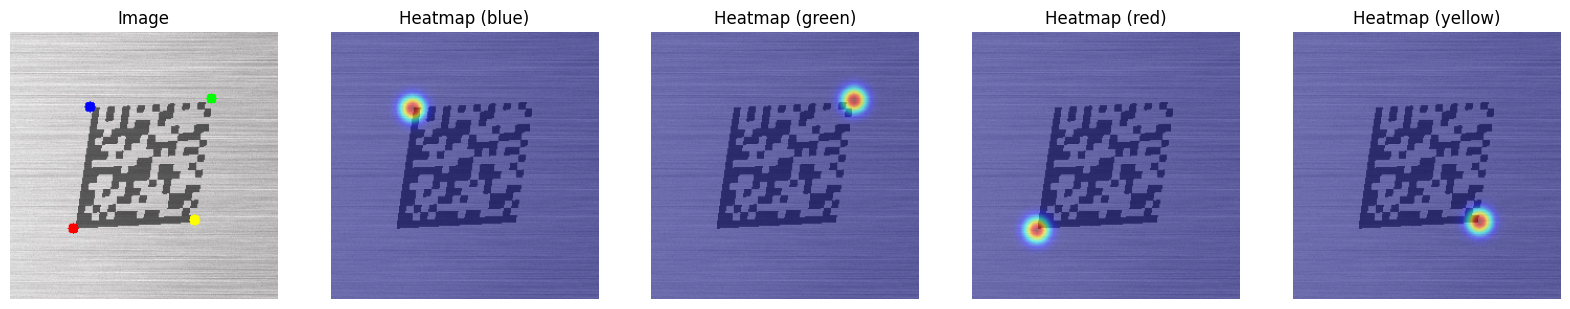

In [35]:
compare_keypoints(model, train_loader)

## Validation Print

Predicted keypoints: [(244, 92), (64, 68), (80, 236), (68, 36)]


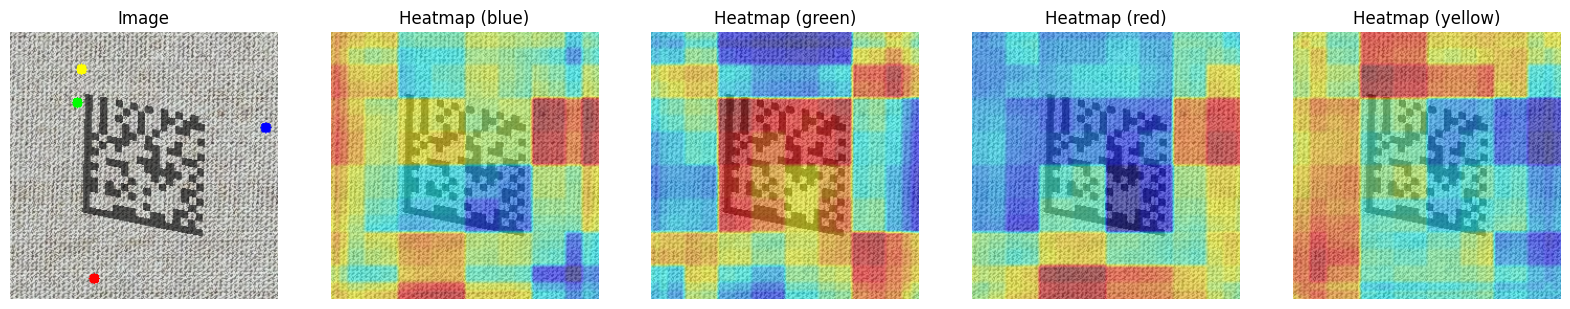

True keypoints: [(68, 56), (184, 80), (68, 172), (184, 196)]


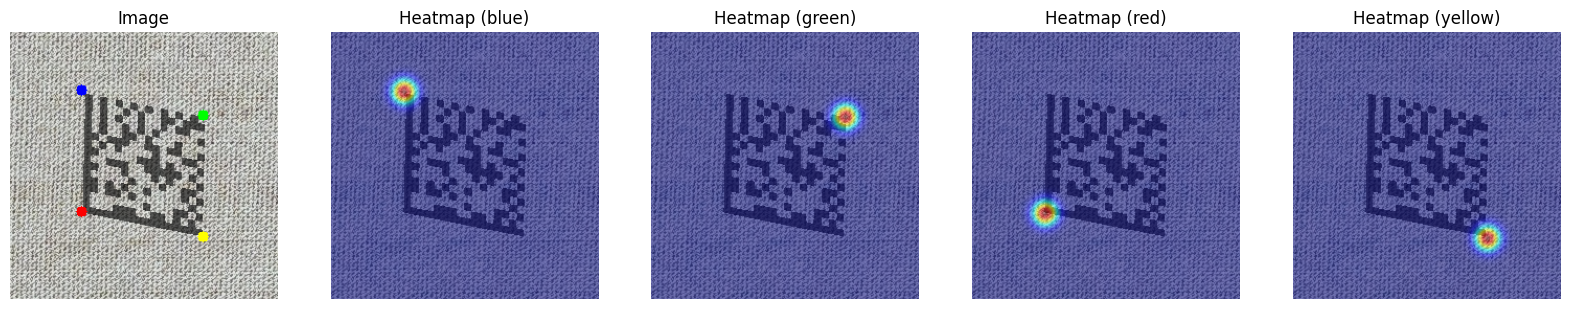

In [36]:
compare_keypoints(model, val_loader)

## Test Print

Predicted keypoints: [(4, 124), (208, 12), (128, 104), (12, 188)]


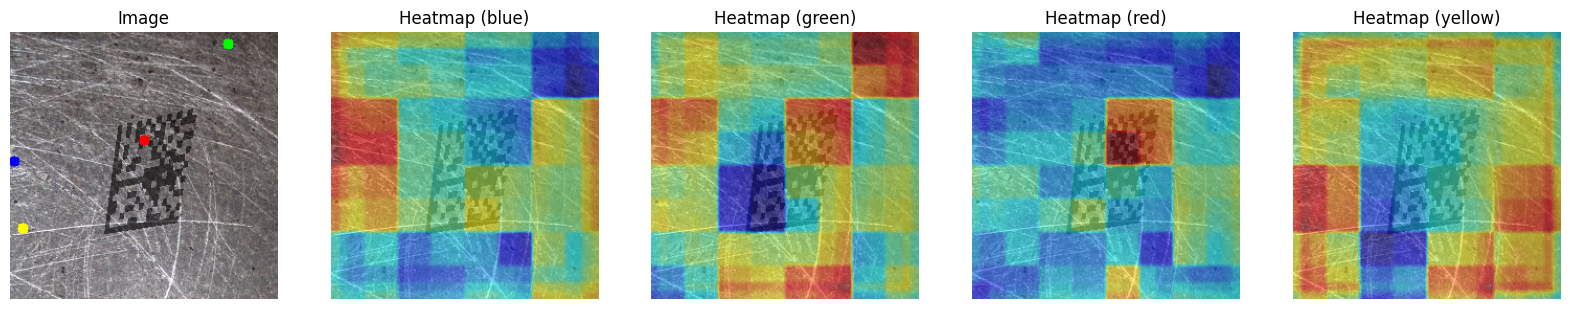

True keypoints: [(100, 88), (180, 72), (88, 192), (160, 180)]


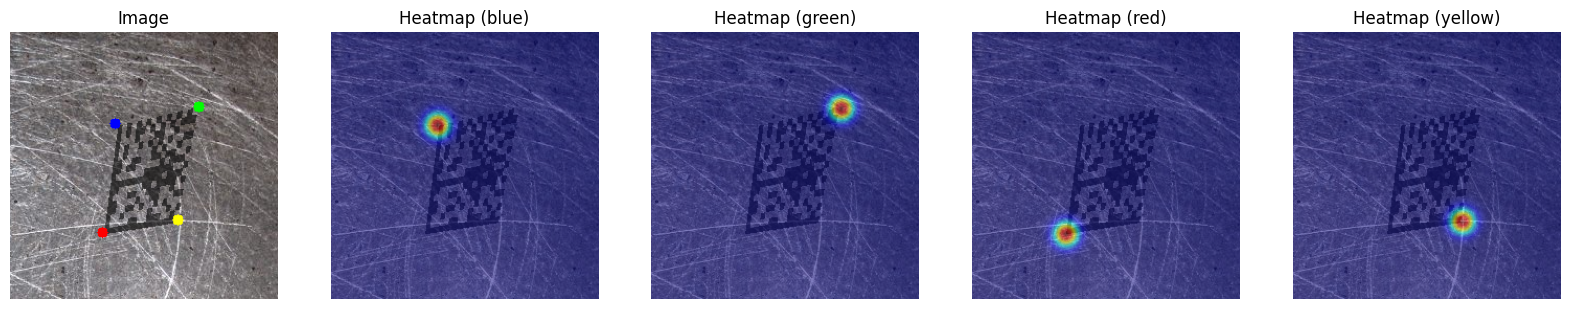

In [37]:
compare_keypoints(model, test_loader)

# Saving Model(s)

In [38]:
# Save all models
torch.save(model, '../models/hourglass_localization_rectification.pth')